# Credit Card Fraud Detection using IsolationForest

이 노트북은 신용 카드 사기 탐지를 위한 **IsolationForest** 모델을 구현합니다. 
IsolationForest는 이상 탐지(Anomaly Detection)에 특화된 앙상블 기법으로, 정상 데이터만을 사용하여 학습하고 이상치를 효과적으로 격리하여 탐지합니다.

## IsolationForest vs Random Forest

| 구분 | IsolationForest | Random Forest |
|------|-----------------|---------------|
| **목적** | 이상 탐지 전용 | 분류/회귀 |
| **학습 방식** | 비지도 학습 (정상 데이터만) | 지도 학습 (레이블 필요) |
| **트리 구조** | 짧은 격리 트리 | 완전한 결정 트리 |
| **출력** | 이상치 점수 | 클래스 확률 |

## IsolationForest 핵심 원리

IsolationForest는 다음과 같은 주요 특징을 가집니다:

1. **격리 기반 이상 탐지**: 이상치가 정상 데이터보다 더 쉽게 격리된다는 원리를 활용합니다.
2. **랜덤 트리 앙상블**: 여러 개의 격리 트리(Isolation Tree)를 생성하여 앙상블 효과를 얻습니다.
3. **비지도 학습**: 정상 데이터만으로 학습하여 레이블이 없는 환경에서도 사용 가능합니다.
4. **효율적인 이상 탐지**: 이상치는 트리에서 더 짧은 경로로 격리되어 빠른 탐지가 가능합니다.
5. **확장성**: 대용량 데이터에서도 효율적으로 동작합니다.

## 예상 성능

- **AUC-ROC**: ~0.94 (우수한 이상 탐지 성능)
- **훈련 시간**: ~0.1초 (매우 빠른 학습)
- **특징**: 정상 거래 패턴 학습 후 사기 거래를 효과적으로 격리

이러한 특성으로 인해 IsolationForest는 사기 탐지와 같은 불균형 데이터셋에서 매우 효과적이며, 특히 새로운 유형의 사기 패턴도 탐지할 수 있는 장점이 있습니다.

In [1]:
# Core libraries for data processing and machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time
import warnings

# 불필요한 경고 무시
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# ==========================================
# Data Loading and Preprocessing Pipeline
# ==========================================

# Load preprocessed credit card fraud dataset
df = pd.read_csv("preprocessed-creditcard.csv")
X = df.drop("Class", axis=1).values  # Feature matrix
y = df["Class"].values                # Target labels (0: normal, 1: fraud)

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Fraud rate: {np.mean(y):.4f} ({np.sum(y)} fraud cases)")

# Stratified train-test split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ====== ANOMALY DETECTION APPROACH ======
# Extract only normal transactions for training 
normal_mask = y_train == 0
X_train_normal = X_train[normal_mask]
print(f"Normal transactions for training: {X_train_normal.shape[0]} samples")

# Feature standardization using Z-score normalization (fit on normal data only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)  # Fit only on normal data
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Dataset loaded: 946 samples, 30 features
Fraud rate: 0.5000 (473 fraud cases)
Normal transactions for training: 378 samples

Training set: (756, 30)
Test set: (190, 30)


In [3]:
# ==========================================
# Configuration
# ==========================================

# TRAINING CONFIGURATION
TRAINING_CONFIG = {
    'n_estimators': 100,          # Number of trees in the forest
    'max_depth': 10,              # Maximum depth of the tree
    'min_samples_split': 2,       # Minimum samples required to split a node
    'min_samples_leaf': 1,        # Minimum samples required at a leaf node
    'bootstrap': True,            # Whether bootstrap samples are used
    'criterion': 'gini',          # Function to measure quality of a split
    'class_weight': 'balanced',   # Weights for classes (useful for imbalanced datasets)
    'random_state': 42,           # Seed for reproducibility
    'n_jobs': -1                  # Use all available cores
}

print(f"\nTraining Configuration: {TRAINING_CONFIG}")
print("="*80)


Training Configuration: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}


In [4]:
def train_isolation_forest_model(X_train_normal, config):
    """
    IsolationForest 모델 학습 함수 (정상 데이터만 사용 - 이상탐지 방식)
    
    Args:
        X_train_normal: 정상 데이터만 포함된 훈련 데이터
        config: 모델 설정 파라미터
        
    Returns:
        model: 학습된 IsolationForest 모델
    """
    print(f"\n{'='*60}")
    print("TRAINING: ISOLATION FOREST MODEL (ANOMALY DETECTION)")
    print(f"{'='*60}")
    
    # 훈련 시작 시간 기록
    start_time = time.time()
    
    # IsolationForest 모델 생성 - 이상탐지 전용 알고리즘
    from sklearn.ensemble import IsolationForest
    
    model = IsolationForest(
        n_estimators=config['n_estimators'],
        max_samples='auto',
        contamination=0.1,  # 예상 이상치 비율
        max_features=1.0,
        bootstrap=config['bootstrap'],
        random_state=config['random_state'],
        n_jobs=config['n_jobs'],
        verbose=1
    )
    
    model.fit(X_train_normal)
    
    # 훈련 종료 시간과 소요 시간 계산
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Trained on {X_train_normal.shape[0]} normal transactions")
    
    return {
        'model': model,
        'training_time': training_time
    }

In [5]:
# 모델 학습
results = {}
try:
    isolation_result = train_isolation_forest_model(X_train_scaled, TRAINING_CONFIG)
    results['isolation_forest'] = isolation_result
    print("IsolationForest model completed successfully")
except Exception as e:
    print(f"IsolationForest model failed: {str(e)}")
    results['isolation_forest'] = {'error': str(e)}


TRAINING: ISOLATION FOREST MODEL (ANOMALY DETECTION)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.



Training completed in 0.35 seconds
Trained on 378 normal transactions
IsolationForest model completed successfully


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished



ISOLATION FOREST MODEL INFORMATION
Number of estimators: 100
Max samples: auto
Contamination: 0.1
Max features: 1.0
Bootstrap: True


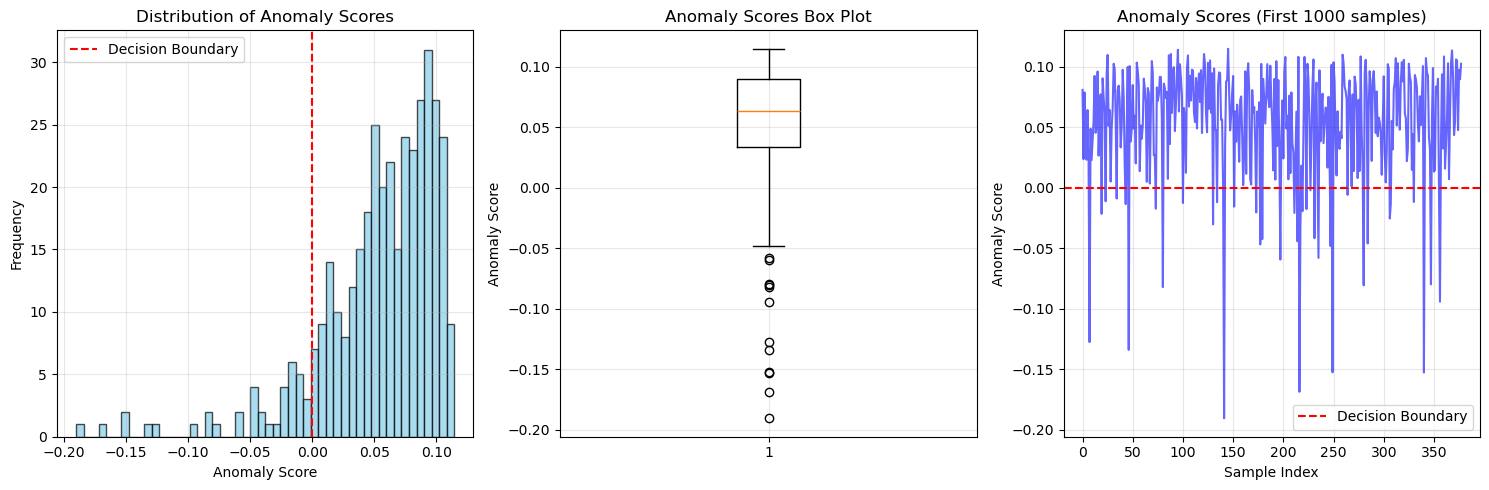


Anomaly Scores Statistics:
  Mean: 0.0541
  Std: 0.0480
  Min: -0.1903
  Max: 0.1146
  Median: 0.0630
  Predicted outlier ratio: 0.1005


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [6]:
# IsolationForest 모델 정보 시각화
def plot_isolation_forest_info(model, X_train, feature_names=None):
    """
    IsolationForest 모델의 정보를 시각화하는 함수
    
    Args:
        model: 학습된 IsolationForest 모델
        X_train: 훈련 데이터
        feature_names: 특성 이름 리스트
    """
    print(f"\n{'='*60}")
    print("ISOLATION FOREST MODEL INFORMATION")
    print(f"{'='*60}")
    
    # 모델 기본 정보
    print(f"Number of estimators: {model.n_estimators}")
    print(f"Max samples: {model.max_samples}")
    print(f"Contamination: {model.contamination}")
    print(f"Max features: {model.max_features}")
    print(f"Bootstrap: {model.bootstrap}")
    
    # 이상치 점수 분포 시각화
    anomaly_scores = model.decision_function(X_train)
    
    plt.figure(figsize=(15, 5))
    
    # 1. 이상치 점수 히스토그램
    plt.subplot(1, 3, 1)
    plt.hist(anomaly_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution of Anomaly Scores')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='red', linestyle='--', label='Decision Boundary')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. 이상치 점수 박스플롯
    plt.subplot(1, 3, 2)
    plt.boxplot(anomaly_scores, vert=True)
    plt.title('Anomaly Scores Box Plot')
    plt.ylabel('Anomaly Score')
    plt.grid(True, alpha=0.3)
    
    # 3. 이상치 점수 vs 인덱스
    plt.subplot(1, 3, 3)
    plt.plot(anomaly_scores[:1000], alpha=0.6, color='blue')  # 처음 1000개만 표시
    plt.title('Anomaly Scores (First 1000 samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Anomaly Score')
    plt.axhline(y=0, color='red', linestyle='--', label='Decision Boundary')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 통계 정보 출력
    print(f"\nAnomaly Scores Statistics:")
    print(f"  Mean: {np.mean(anomaly_scores):.4f}")
    print(f"  Std: {np.std(anomaly_scores):.4f}")
    print(f"  Min: {np.min(anomaly_scores):.4f}")
    print(f"  Max: {np.max(anomaly_scores):.4f}")
    print(f"  Median: {np.median(anomaly_scores):.4f}")
    
    # 예측된 이상치 비율
    outliers = model.predict(X_train)
    outlier_ratio = np.sum(outliers == -1) / len(outliers)
    print(f"  Predicted outlier ratio: {outlier_ratio:.4f}")

# IsolationForest 모델 정보 시각화 (학습이 성공적으로 완료된 경우)
if 'error' not in results['isolation_forest']:
    # 특성 이름이 없는 경우 번호로 대체
    feature_names = [f"Feature_{i}" for i in range(X_train_scaled.shape[1])]
    plot_isolation_forest_info(results['isolation_forest']['model'], X_train_scaled, feature_names)

In [7]:
def evaluate_model(model, X_test, y_test):
    """
    IsolationForest 모델 평가 함수
    
    Args:
        model: 학습된 IsolationForest 모델
        X_test: 테스트 데이터
        y_test: 테스트 레이블
        
    Returns:
        dict: 평가 결과를 포함한 딕셔너리
    """
    print(f"\n{'='*60}")
    print("MODEL EVALUATION")
    print(f"{'='*60}")
    
    # 이상치 점수 계산 (음수: 정상, 양수: 이상)
    anomaly_scores = model.decision_function(X_test)
    
    # 점수를 확률로 변환 (시그모이드 변환)
    y_pred_proba = 1 / (1 + np.exp(anomaly_scores))
    
    # 다양한 임계값에서 성능 평가
    thresholds = np.arange(0.1, 1.0, 0.1)
    results = []
    
    print("Threshold evaluation:")
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # 혼동 행렬 계산
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
        
        # 평가 지표 계산
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        gmean = (rec * spec) ** 0.5
        
        results.append({
            'threshold': threshold,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'specificity': spec,
            'gmean': gmean,
            'confusion_matrix': {
                'tn': int(tn),
                'fp': int(fp),
                'fn': int(fn),
                'tp': int(tp)
            }
        })
        
        print(f"  T={threshold:.1f}: Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} "
              f"F1={f1:.3f} G-Mean={gmean:.3f}")
    
    # AUC-ROC 점수 계산
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # G-Mean 기준으로 최적의 임계값 찾기
    best_result = max(results, key=lambda x: x['gmean'])
    
    print("\nRESULTS SUMMARY:")
    print(f"  AUC-ROC Score: {auc:.4f}")
    print(f"  Best Threshold: {best_result['threshold']:.1f} (G-Mean: {best_result['gmean']:.3f})")
    print(f"  Best Performance: Acc={best_result['accuracy']:.3f}, "
          f"Prec={best_result['precision']:.3f}, Rec={best_result['recall']:.3f}, "
          f"F1={best_result['f1_score']:.3f}")
    
    # 최적의 임계값에서의 혼동 행렬
    cm = best_result['confusion_matrix']
    print(f"\nConfusion Matrix at threshold={best_result['threshold']:.1f}:")
    print(f"  True Negative: {cm['tn']}, False Positive: {cm['fp']}")
    print(f"  False Negative: {cm['fn']}, True Positive: {cm['tp']}")
    
    return {
        'auc': auc,
        'best_threshold': best_result['threshold'],
        'best_metrics': best_result,
        'all_results': results
    }

# 모델 평가 (학습이 성공적으로 완료된 경우)
if 'error' not in results['isolation_forest']:
    eval_results = evaluate_model(results['isolation_forest']['model'], X_test_scaled, y_test)
    results['isolation_forest']['evaluation'] = eval_results


MODEL EVALUATION
Threshold evaluation:
  T=0.1: Acc=0.500 Prec=0.500 Rec=1.000 F1=0.667 G-Mean=0.000
  T=0.2: Acc=0.500 Prec=0.500 Rec=1.000 F1=0.667 G-Mean=0.000
  T=0.3: Acc=0.500 Prec=0.500 Rec=1.000 F1=0.667 G-Mean=0.000
  T=0.4: Acc=0.500 Prec=0.500 Rec=1.000 F1=0.667 G-Mean=0.000
  T=0.5: Acc=0.889 Prec=0.885 Rec=0.895 F1=0.890 G-Mean=0.889
  T=0.6: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000
  T=0.7: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000
  T=0.8: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000
  T=0.9: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000

RESULTS SUMMARY:
  AUC-ROC Score: 0.9398
  Best Threshold: 0.5 (G-Mean: 0.889)
  Best Performance: Acc=0.889, Prec=0.885, Rec=0.895, F1=0.890

Confusion Matrix at threshold=0.5:
  True Negative: 84, False Positive: 11
  False Negative: 10, True Positive: 85


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


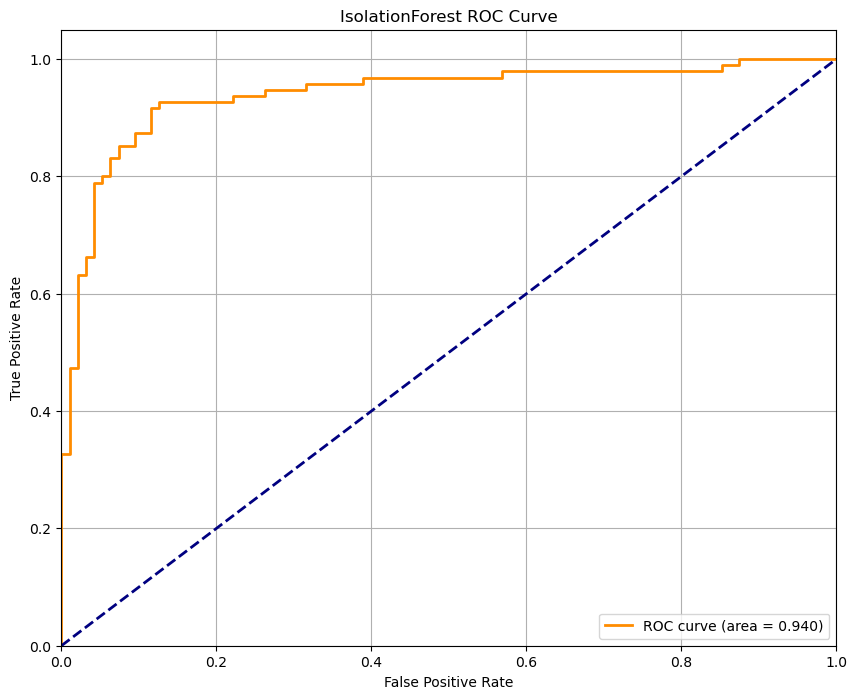

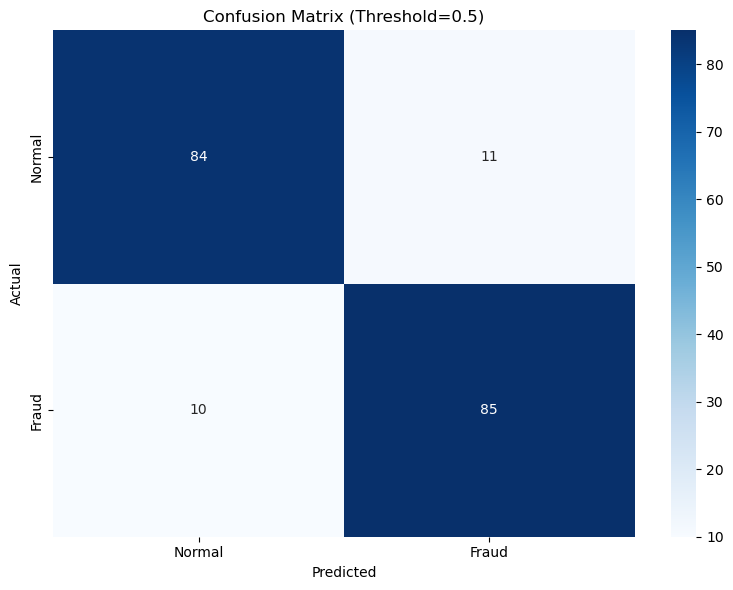

In [8]:
# ROC 곡선 시각화
def plot_roc_curve(y_test, y_scores, title="ROC Curve"):
    """
    ROC 곡선을 시각화하는 함수
    
    Args:
        y_test: 실제 레이블
        y_scores: 예측 확률 또는 점수
        title: 그래프 제목
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# 혼동 행렬 시각화
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    혼동 행렬을 시각화하는 함수
    
    Args:
        y_true: 실제 레이블
        y_pred: 예측 레이블
        labels: 레이블 이름 리스트
        title: 그래프 제목
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels if labels else ['Normal', 'Fraud'],
                yticklabels=labels if labels else ['Normal', 'Fraud'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# ROC 곡선과 최적 임계값에서의 혼동 행렬 시각화
if 'error' not in results['isolation_forest'] and 'evaluation' in results['isolation_forest']:
    # ROC 곡선
    anomaly_scores = results['isolation_forest']['model'].decision_function(X_test_scaled)
    y_scores = 1 / (1 + np.exp(anomaly_scores))  # Sigmoid transformation
    plot_roc_curve(y_test, y_scores, title='IsolationForest ROC Curve')
    
    # 최적 임계값에서의 혼동 행렬
    best_threshold = results['isolation_forest']['evaluation']['best_threshold']
    y_pred = (y_scores >= best_threshold).astype(int)
    plot_confusion_matrix(y_test, y_pred, title=f"Confusion Matrix (Threshold={best_threshold:.1f})")

In [9]:
# IsolationForest 하이퍼파라미터 튜닝
def tune_isolation_forest_hyperparameters(X_train_normal, verbose=True):
    """
    IsolationForest 모델의 하이퍼파라미터를 최적화하는 함수 
    
    Args:
        X_train_normal: 정상 데이터만 포함된 훈련 데이터
        verbose: 상세 출력 여부
        
    Returns:
        dict: 최적의 파라미터와 모델을 포함한 딕셔너리
    """
    print(f"\n{'='*60}") 
    print("ISOLATION FOREST HYPERPARAMETER TUNING")
    print(f"{'='*60}")
    
    from sklearn.ensemble import IsolationForest
    from sklearn.model_selection import ParameterGrid
    
    # 튜닝 시작 시간 기록
    start_time = time.time()
    
    # 탐색할 파라미터 그리드 (IsolationForest 전용)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_samples': ['auto', 0.5, 0.8],
        'contamination': [0.05, 0.1, 0.15],
        'max_features': [0.5, 0.8, 1.0],
        'bootstrap': [True, False]
    }
    
    best_score = -1
    best_params = None
    best_model = None
    
    # 그리드 서치 수동 구현 (IsolationForest는 GridSearchCV 지원이 제한적)
    param_combinations = list(ParameterGrid(param_grid))
    total_combinations = len(param_combinations)
    
    print(f"총 {total_combinations}개의 파라미터 조합을 테스트합니다...")
    
    for i, params in enumerate(param_combinations, 1):
        if verbose and i % 10 == 0:
            print(f"진행률: {i}/{total_combinations} ({i/total_combinations*100:.1f}%)")
        
        try:
            # 모델 생성 및 학습
            model = IsolationForest(
                random_state=42,
                n_jobs=1,
                verbose=0,
                **params
            )
            
            model.fit(X_train_normal)
            
            # 간단한 점수 계산 (실제로는 별도 검증셋이 필요하지만 여기서는 단순화)
            # 이상치 탐지에서는 전통적인 교차검증이 어려우므로 일관성 점수 사용
            scores = model.decision_function(X_train_normal)
            score = np.mean(scores)  # 평균 이상치 점수
            
            if score > best_score:
                best_score = score
                best_params = params.copy()
                best_model = model
                
        except Exception as e:
            if verbose:
                print(f"파라미터 조합 {params}에서 오류 발생: {str(e)}")
            continue
    
    # 튜닝 종료 시간과 소요 시간 계산
    tuning_time = time.time() - start_time
    
    if verbose:
        print(f"\n튜닝 완료 시간: {tuning_time:.2f}초")
        print(f"최적 파라미터: {best_params}")
        print(f"최적 점수: {best_score:.4f}")
    
    return {
        'best_params': best_params,
        'best_score': best_score,
        'best_model': best_model,
        'tuning_time': tuning_time
    }

# 하이퍼파라미터 튜닝 실행
try:
    print("IsolationForest 하이퍼파라미터 튜닝을 시작합니다...")
    tuning_results = tune_isolation_forest_hyperparameters(X_train_scaled)
    results['tuning'] = tuning_results
    
    # 튜닝된 모델 평가
    tuned_model = tuning_results['best_model']
    print("튜닝된 모델을 평가합니다...")
    tuned_eval = evaluate_model(tuned_model, X_test_scaled, y_test)
    results['tuned_isolation_forest'] = {
        'model': tuned_model,
        'evaluation': tuned_eval
    }
    
    print("하이퍼파라미터 튜닝이 성공적으로 완료되었습니다!")
    
    # 원본 모델과 튜닝된 모델 성능 비교
    original_auc = results['isolation_forest']['evaluation']['auc']
    tuned_auc = tuned_eval['auc']
    
    print(f"\n성능 비교:")
    print(f"  원본 IsolationForest AUC: {original_auc:.4f}")
    print(f"  튜닝된 IsolationForest AUC: {tuned_auc:.4f}")
    print(f"  개선 정도: {tuned_auc - original_auc:+.4f}")
    
    # 최적 파라미터 상세 정보
    print(f"\n최적 파라미터 상세:")
    for param, value in tuning_results['best_params'].items():
        print(f"  - {param}: {value}")
    
except Exception as e:
    print(f"IsolationForest 하이퍼파라미터 튜닝 실패: {str(e)}")
    results['tuning'] = {'error': str(e)}

IsolationForest 하이퍼파라미터 튜닝을 시작합니다...

ISOLATION FOREST HYPERPARAMETER TUNING
총 162개의 파라미터 조합을 테스트합니다...
진행률: 10/162 (6.2%)
진행률: 10/162 (6.2%)
진행률: 20/162 (12.3%)
진행률: 20/162 (12.3%)
진행률: 30/162 (18.5%)
진행률: 30/162 (18.5%)
진행률: 40/162 (24.7%)
진행률: 40/162 (24.7%)
진행률: 50/162 (30.9%)
진행률: 50/162 (30.9%)
진행률: 60/162 (37.0%)
진행률: 60/162 (37.0%)
진행률: 70/162 (43.2%)
진행률: 70/162 (43.2%)
진행률: 80/162 (49.4%)
진행률: 80/162 (49.4%)
진행률: 90/162 (55.6%)
진행률: 90/162 (55.6%)
진행률: 100/162 (61.7%)
진행률: 100/162 (61.7%)
진행률: 110/162 (67.9%)
진행률: 110/162 (67.9%)
진행률: 120/162 (74.1%)
진행률: 120/162 (74.1%)
진행률: 130/162 (80.2%)
진행률: 130/162 (80.2%)
진행률: 140/162 (86.4%)
진행률: 140/162 (86.4%)
진행률: 150/162 (92.6%)
진행률: 150/162 (92.6%)
진행률: 160/162 (98.8%)
진행률: 160/162 (98.8%)

튜닝 완료 시간: 67.39초
최적 파라미터: {'bootstrap': True, 'contamination': 0.05, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}
최적 점수: 0.1054
튜닝된 모델을 평가합니다...

MODEL EVALUATION
Threshold evaluation:
  T=0.1: Acc=0.500 Prec=0.500 Rec=1.000 F1